In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate, LeakyReLU, Dropout, ReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

# Data Downloading

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d yewtsing/pretty-face
! unzip "/content/pretty-face.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/layout/layout/020203.png  
  inflating: /content/dataset/layout/layout/020215.png  
  inflating: /content/dataset/layout/layout/020216.png  
  inflating: /content/dataset/layout/layout/020233.png  
  inflating: /content/dataset/layout/layout/020259.png  
  inflating: /content/dataset/layout/layout/020276.png  
  inflating: /content/dataset/layout/layout/020285.png  
  inflating: /content/dataset/layout/layout/020303.png  
  inflating: /content/dataset/layout/layout/020322.png  
  inflating: /content/dataset/layout/layout/020326.png  
  inflating: /content/dataset/layout/layout/020337.png  
  inflating: /content/dataset/layout/layout/020354.png  
  inflating: /content/dataset/layout/layout/020358.png  
  inflating: /content/dataset/layout/layout/020367.png  
  inflating: /content/dataset/layout/layout/020370.png  
  inflating: /content/dataset/layout/layout/020381.png  
  inflating: /content/dataset/layout/

# Data Loading

In [49]:
image = cv2.imread("/content/dataset/face/face/000025.png")
height, width, channels = image.shape
print("Height:", height, "Width:", width, "Channel:", channels)

image = cv2.imread("/content/dataset/sketch/sketch/000044_edges.jpg")
height, width, channels = image.shape
print("Height:", height, "Width:", width, "Channel:", channels)

Height: 512 Width: 512 Channel: 3
Height: 512 Width: 512 Channel: 3


In [53]:
max(image)

ValueError: ignored

In [4]:
face_data_dir = "/content/dataset/face/face"
sketch_data_dir = "/content/dataset/sketch/sketch"
face_data_path = sorted([os.path.join(face_data_dir, fname) for fname in os.listdir(face_data_dir)])
sketch_data_path = sorted([os.path.join(sketch_data_dir, fname) for fname in os.listdir(sketch_data_dir)])

print("Number of face images in dataset:", len(face_data_path))
print("Number of sketch images in dataset:", len(sketch_data_path))

Number of face images in dataset: 3318
Number of sketch images in dataset: 3318


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((face_data_path, sketch_data_path))

In [6]:
IMG_SIZE = 256
def get_images(face_image_path, sketch_image_path):
  face_image = tf.io.decode_png(tf.io.read_file(face_image_path), channels=3)
  face_image = tf.cast(tf.image.resize(face_image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)

  sketch_image = tf.io.decode_jpeg(tf.io.read_file(sketch_image_path), channels=3)
  sketch_image = tf.cast(tf.image.resize(sketch_image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)

  return face_image, sketch_image

In [7]:
dataset = dataset.map(get_images)

In [8]:
for black_image, color_image in dataset.take(1):
  print(black_image.shape)
  print(color_image.shape)

(256, 256, 3)
(256, 256, 3)


# Data Visulization

In [9]:
def plot_images(black_image, color_image):
  fig, arr = plt.subplots(1, 3, figsize=(20, 4))
  arr[0].imshow(black_image, cmap='gray')
  arr[0].set_title("Black Image")
  arr[0].axis("off")
  arr[1].imshow(black_image, cmap='bone')
  arr[1].set_title("Black Image")
  arr[1].axis("off")
  arr[2].imshow(color_image)
  arr[2].set_title("Color Image")
  arr[2].axis("off")

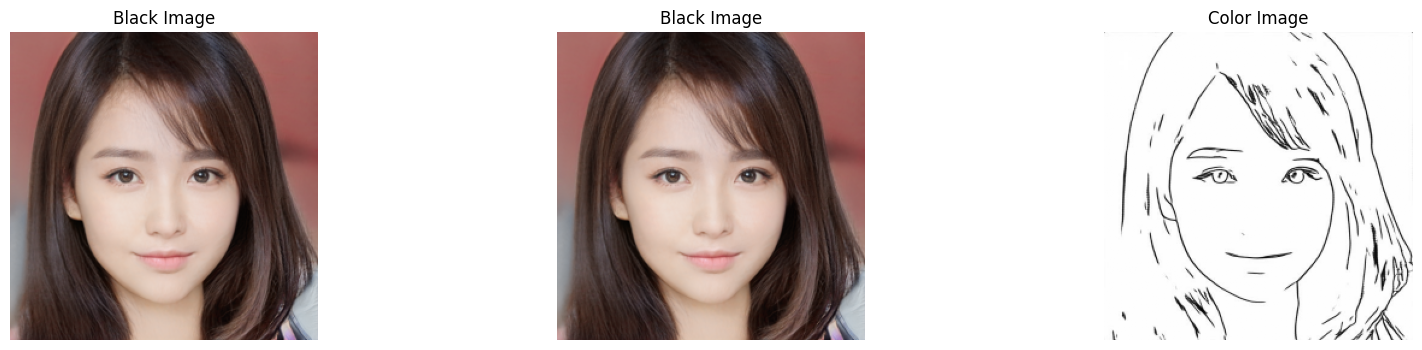

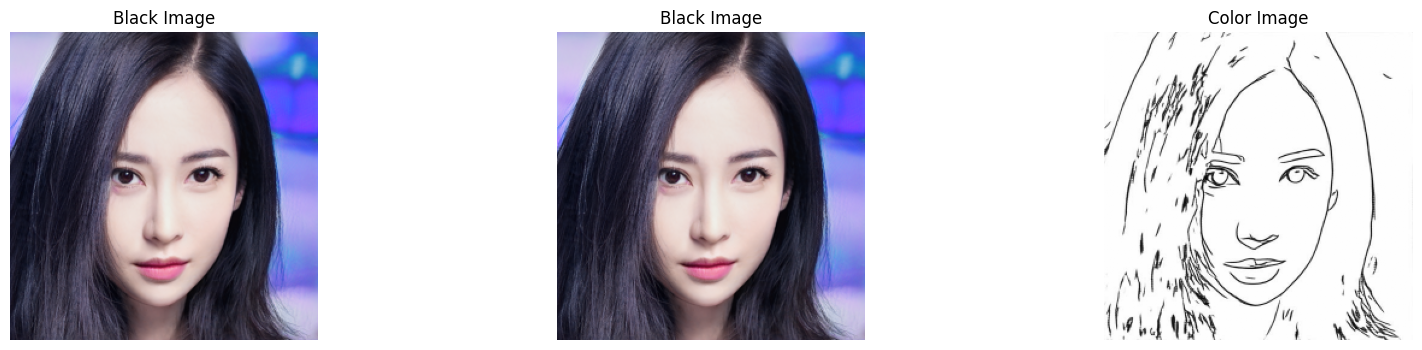

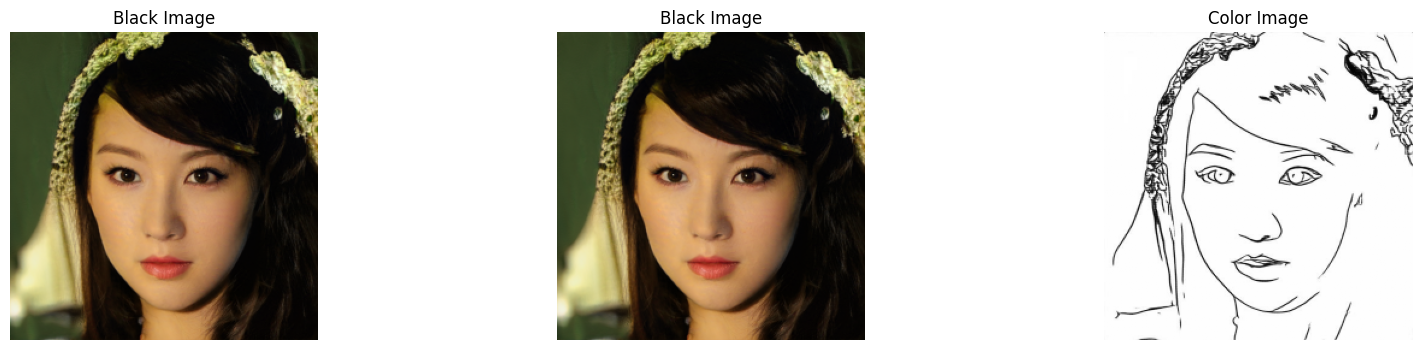

In [10]:
for black_image, color_image in dataset.take(3):
  plot_images(black_image/255, color_image/255)

# Split dataset

In [11]:
def split_dataset(dataset, TRAIN_RATIO):
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
  test_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size))

  return train_dataset, test_dataset

In [12]:
train_dataset, test_dataset = split_dataset(dataset, TRAIN_RATIO=0.95)

In [13]:
print("Number of Training Examples in Training data:", len(train_dataset))
print("Number of Testing Examples in Testing data:", len(test_dataset))

Number of Training Examples in Training data: 3152
Number of Testing Examples in Testing data: 166


# Data Augumentation

In [14]:
import albumentations as A

transforms = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1),
    A.RandomRotate90(p=1)
])

In [15]:
def aug_albument(black_image, color_image):
  augmented = transforms(image=black_image, mask=color_image)
  return [tf.convert_to_tensor(augmented['image'], dtype=tf.float32),
          tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)]

In [16]:
def process_data(black_image, color_image):
  augmented = tf.numpy_function(func=aug_albument, inp=[black_image, color_image], Tout=(tf.float32, tf.float32))
  return augmented[0], augmented[1]

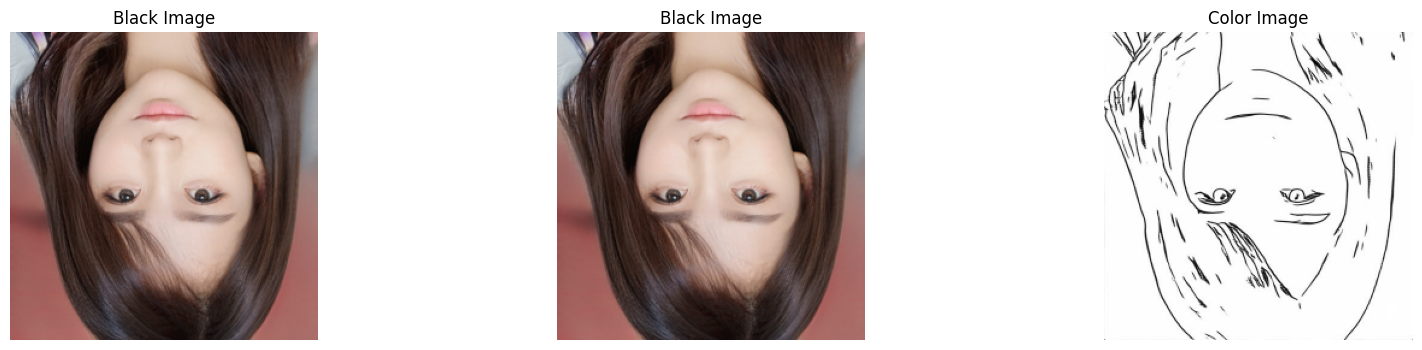

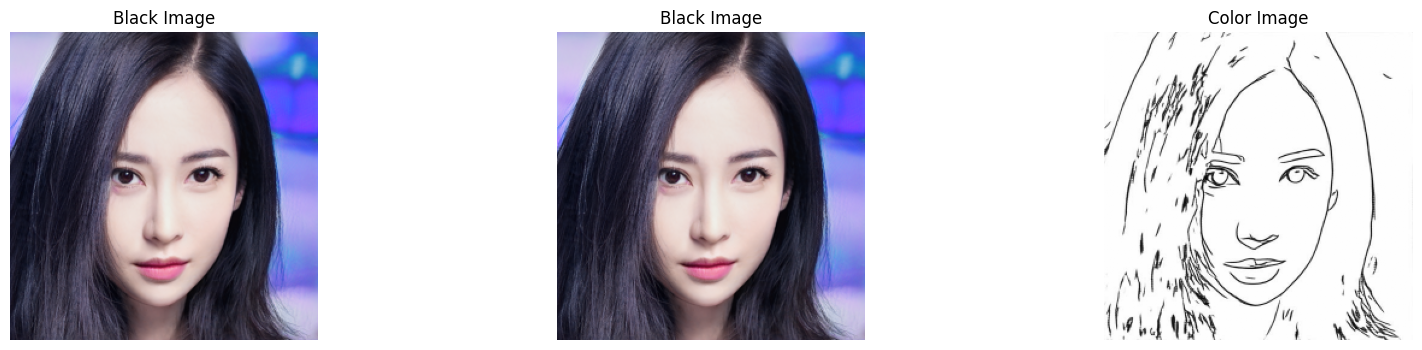

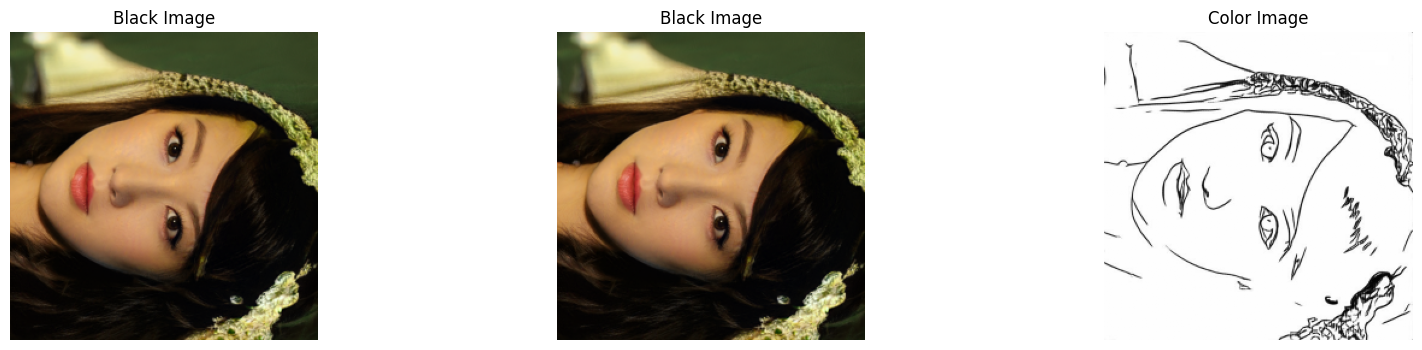

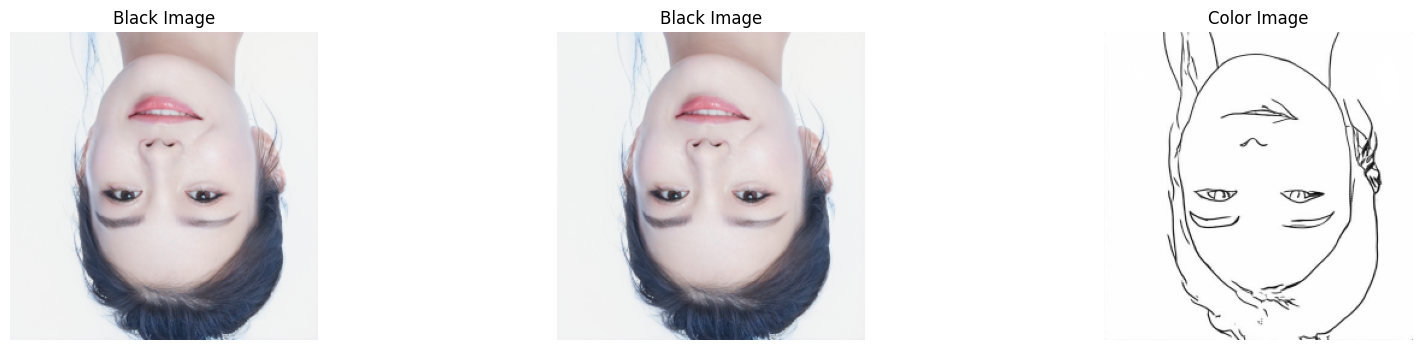

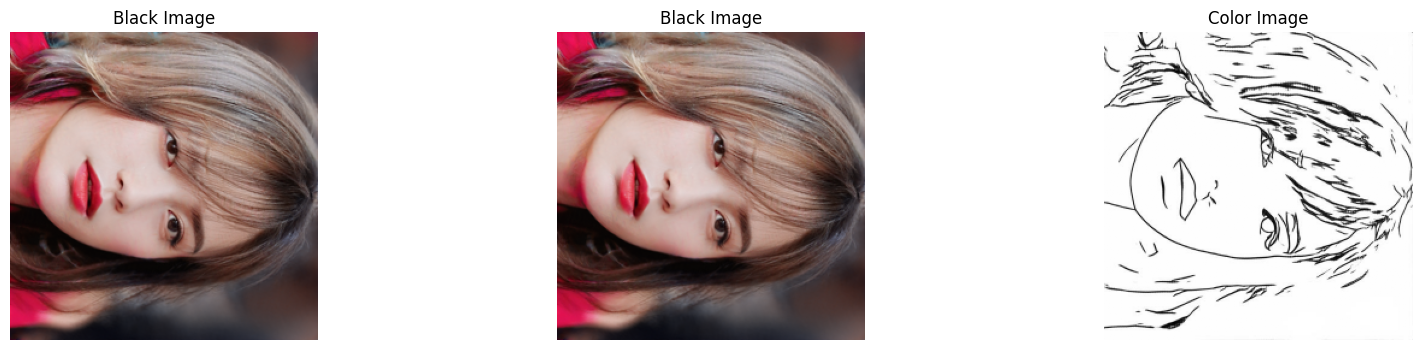

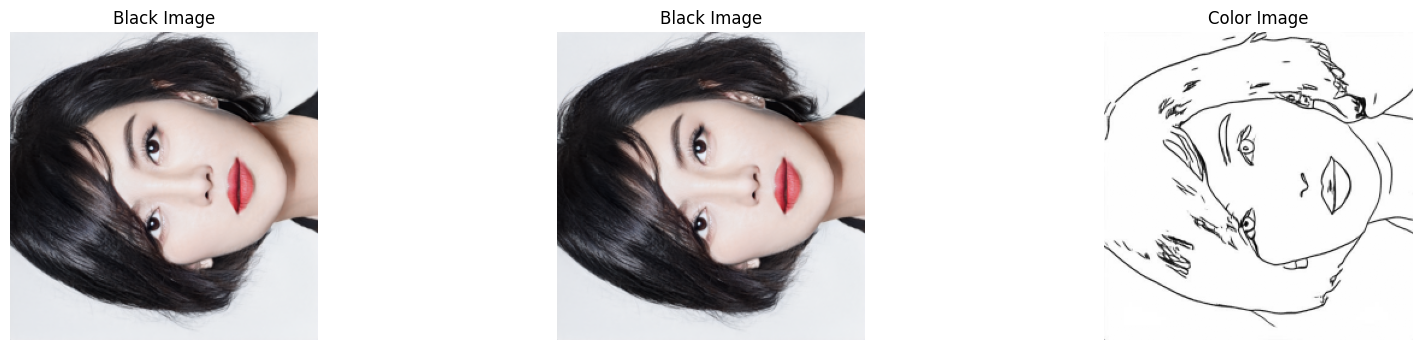

In [18]:
for black_image, color_image in train_dataset.take(6):
  black_aug_image, color_aug_image = process_data(black_image, color_image)
  plot_images(black_aug_image/255, color_aug_image/255)

# Data Loding

In [19]:
def preprocess(black_image, color_image):
  black_image = tf.cast(black_image, tf.float32) / 127.5 - 1.0
  color_image = tf.cast(color_image, tf.float32) / 127.5 - 1.0
  return black_image, color_image

In [20]:
train_dataset = (
    train_dataset
    .map(preprocess)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE))

In [21]:
test_dataset = (
    test_dataset
    .map(preprocess)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE))

In [22]:
for color_image, black_mask in train_dataset.take(1):
  print(color_image.shape)
  print(black_mask.shape)

(64, 256, 256, 3)
(64, 256, 256, 3)


# Model

In [23]:
def downsample(filters, kernel_size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0.0, 0.02)

  model = Sequential()
  model.add(Conv2D(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer,
             use_bias=False))
  if apply_batchnorm:
    model.add(BatchNormalization())
  model.add(LeakyReLU())

  return model

In [24]:
def upsample(filters, kernel_size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.0, 0.02)
  model = Sequential()
  model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same', kernel_initializer=initializer,
                      use_bias=False))
  model.add(BatchNormalization())
  if apply_dropout:
    model.add(Dropout(0.5))
  model.add(ReLU())

  return model

# Generator

In [25]:
input_layer = Input(shape=(256, 256, 3))

downsample_filters = [64, 128, 256, 512, 512, 512, 512, 512]
batch_norm = [False, True, True, True, True, True, True, True]

upsample_filters = [512, 512, 512, 512, 256, 128, 64]
drop_out = [True, True, True, False, False, False, False]

x = input_layer
stores = []

for filter, batchnorm  in zip(downsample_filters, batch_norm):
  x = downsample(filter, kernel_size=4, apply_batchnorm=batchnorm)(x)
  stores.append(x)

for filter, dropout in zip(upsample_filters, drop_out):
  x = tf.concat([x, stores.pop()], axis=-1)
  x = upsample(filter, kernel_size=4, apply_dropout=dropout)(x)

initializer = tf.random_normal_initializer(0., 0.02)
output_layer = Conv2DTranspose(filters=3, kernel_size=4, strides=2, padding='same',
                    kernel_initializer=initializer,
                    activation='tanh')(x)

generator = Model(inputs=input_layer, outputs=output_layer)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

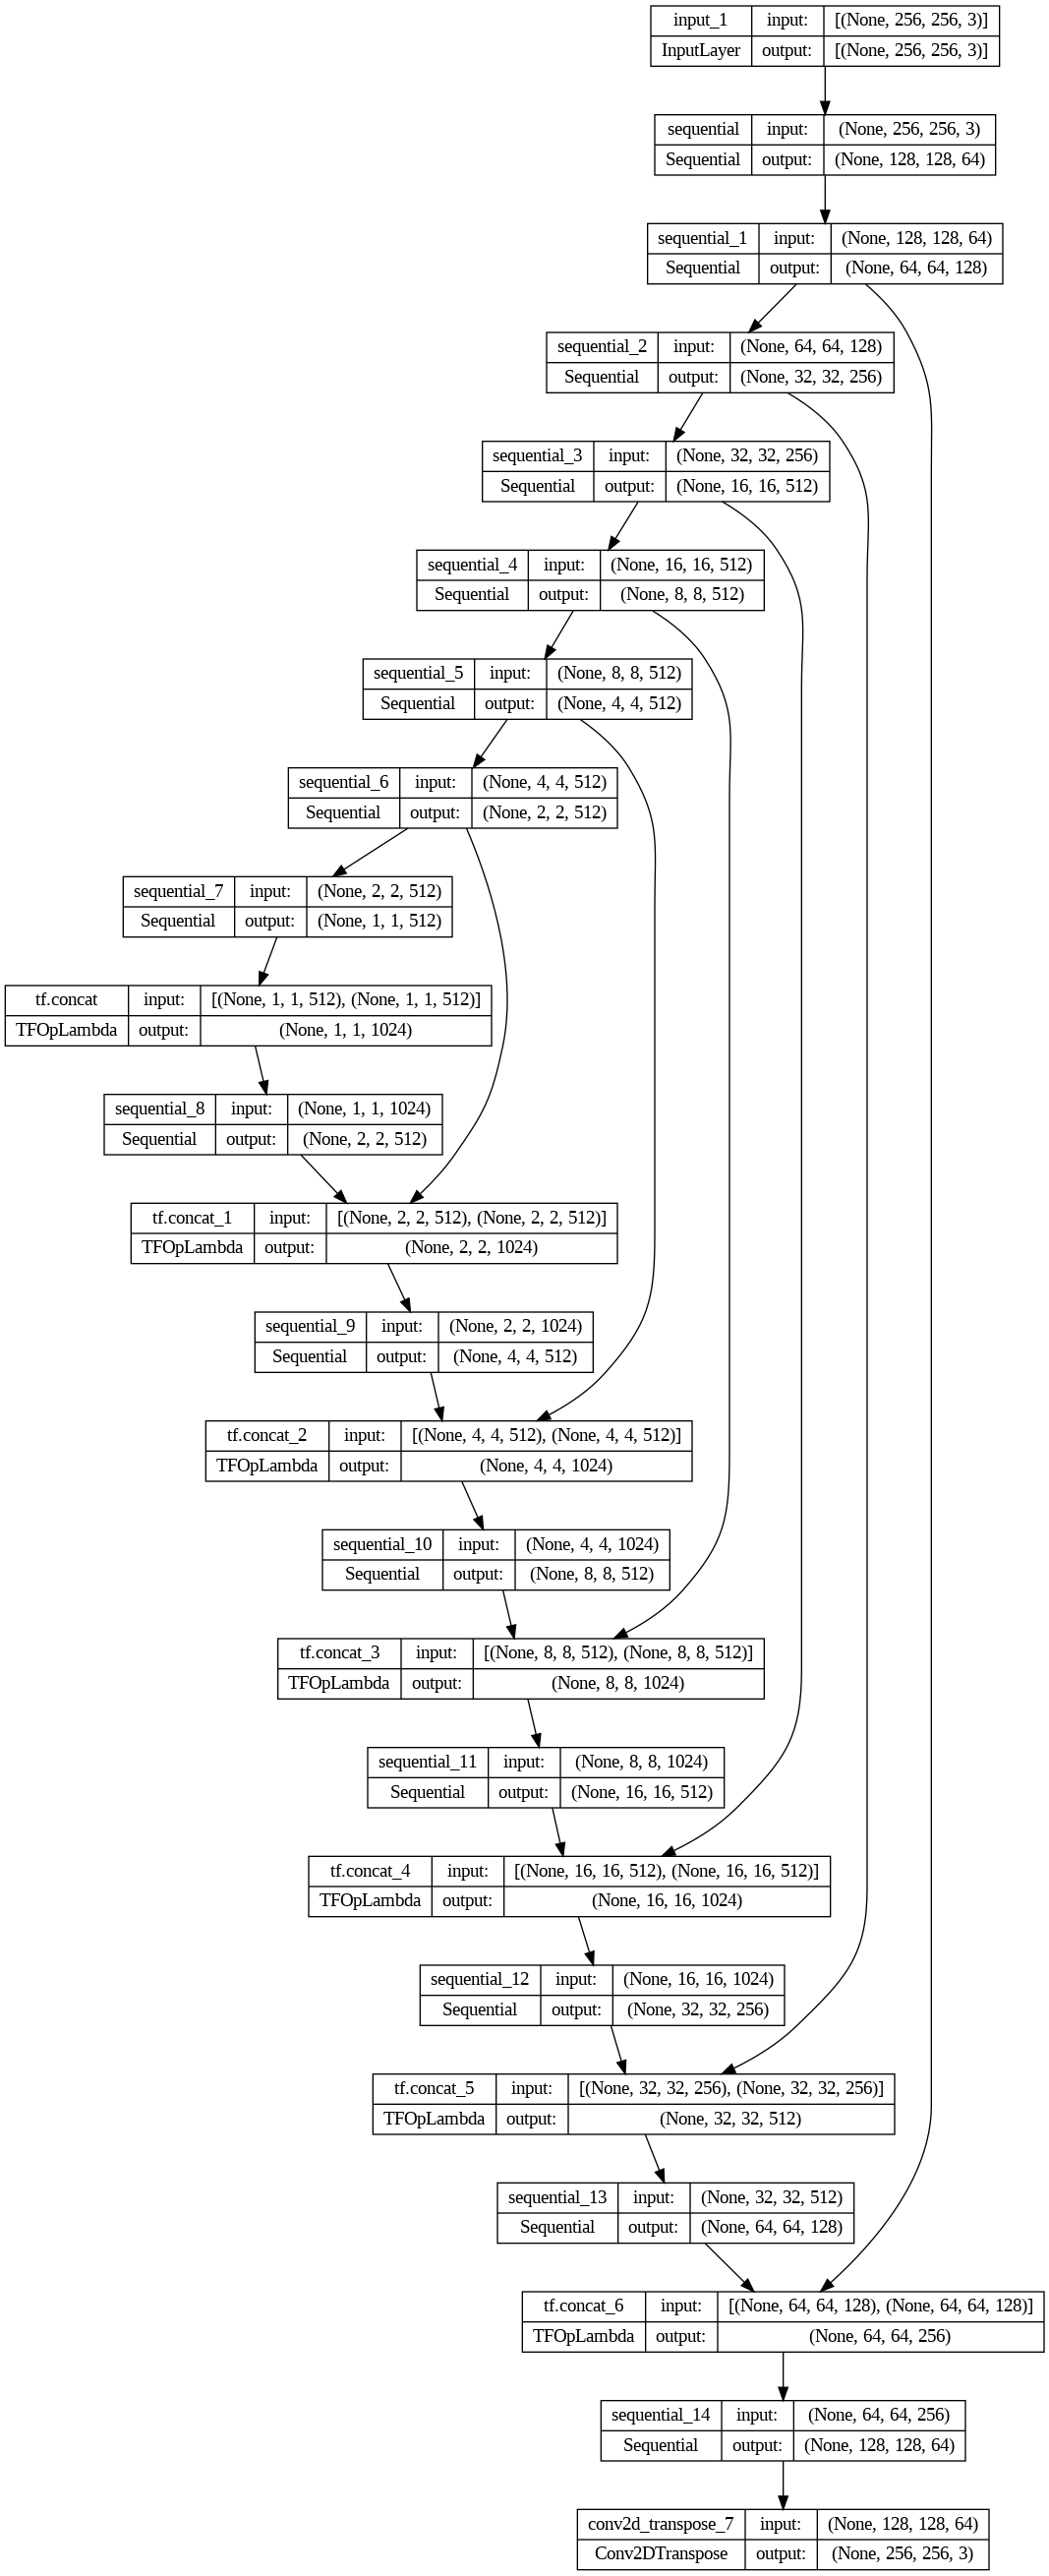

In [26]:
plot_model(generator, show_shapes=True)

# Discriminator

In [27]:
input_layer = Input(shape=[256, 256, 3], name='input_image')
target_layer = Input(shape=[256, 256, 3], name='target_image')

x = concatenate([input_layer, target_layer])
x = downsample(filters=64, kernel_size=4, apply_batchnorm=False)(x)
x = downsample(filters=128, kernel_size=4)(x)
x = downsample(filters=256, kernel_size=4)(x)

x = ZeroPadding2D()(x)
initializer = tf.random_normal_initializer(0.0, 0.02)
x = Conv2D(filters=512, kernel_size=4, strides=1, kernel_initializer=initializer,
           use_bias=False)(x)

x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = ZeroPadding2D()(x)

output_layer = Conv2D(filters=3, kernel_size=4, strides=1, kernel_initializer=initializer)(x)

discriminator = Model(inputs=[input_layer, target_layer], outputs=output_layer)
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_image[0][0]',         
                                                                     'target_image[0][0]']        
                                                                                                  
 sequential_15 (Sequential)  (None, 128, 128, 64)         6144      ['concatenate[0][0]']   

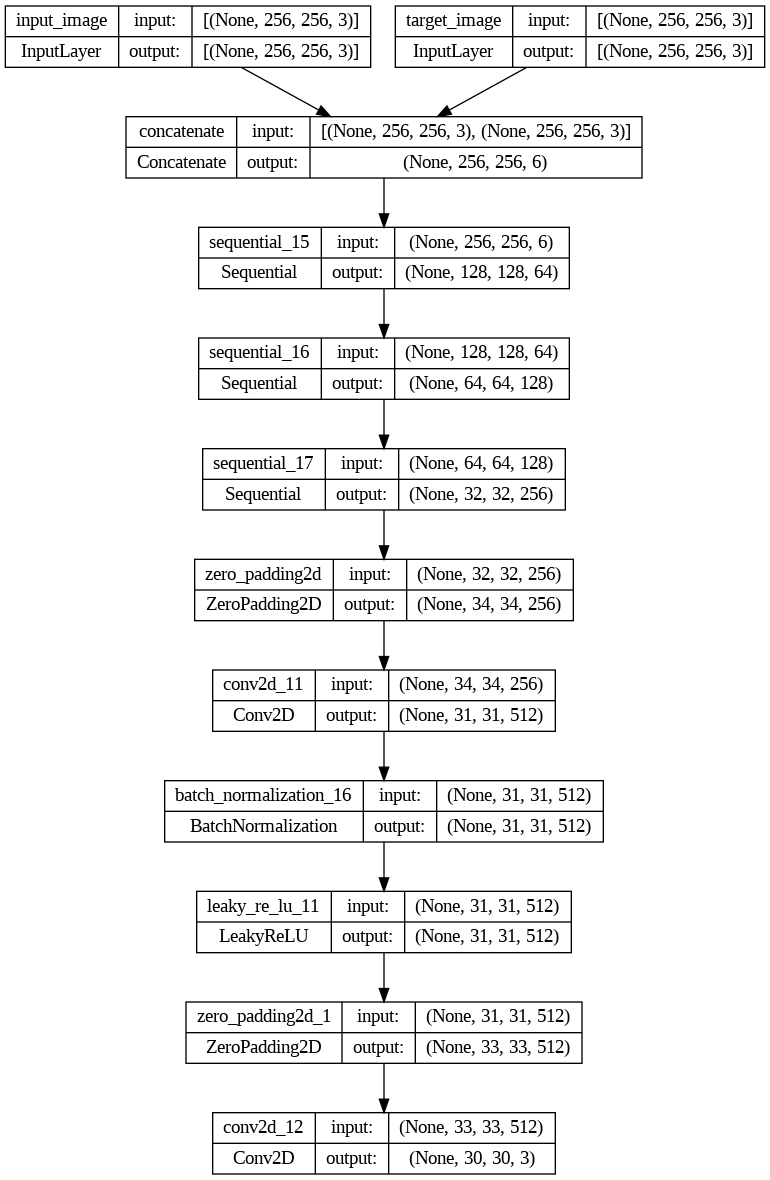

In [28]:
plot_model(discriminator, show_shapes=True)

In [29]:
loss = BinaryCrossentropy(from_logits=True)

In [30]:
LAMBDA = 100
def generator_loss(dis_output, gan_output, target):
  gan_loss = loss(tf.ones_like(dis_output), dis_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gan_output))
  total_gan_loss = gan_loss + (LAMBDA * l1_loss)
  return total_gan_loss, gan_loss, l1_loss

In [31]:
def discriminator_loss(dic_real, dis_generated):
  real_loss = loss(tf.ones_like(dic_real), dic_real)
  gen_loss = loss(tf.ones_like(dis_generated), dis_generated)
  total_disc_loss = real_loss + gen_loss
  return total_disc_loss

In [32]:
def convert_to_grayscale_with_channels(image):
    gray_image = tf.image.rgb_to_grayscale(image)
    gray_image = tf.image.grayscale_to_rgb(gray_image)
    return gray_image

In [33]:
! mkdir generated

In [34]:
class ShowImage(Callback):
  def on_epoch_end(self, epoch, logs=None):
    for black_image, color_image in test_dataset.take(1):
      for i in range(1):
          expanded_black_image = tf.expand_dims(black_image[i], axis=0)
          gray_image = convert_to_grayscale_with_channels(expanded_black_image)
          gen_image = pix2pix.generator(gray_image)[0]

          plt.figure(figsize=(20, 8))

          plt.subplot(1, 3, 1)
          plt.title('Original Color Image')
          plt.imshow(color_image[i].numpy())
          plt.axis('off')

          plt.subplot(1, 3, 2)
          plt.title('Grayscale Image')
          plt.imshow(expanded_black_image[0].numpy(), cmap='gray')
          plt.axis('off')

          plt.subplot(1, 3, 3)
          plt.title('Generated Colorized Image')
          plt.imshow(gen_image.numpy())
          plt.axis('off')
          plt.savefig("generated/gan_images_epoch_{}.png".format(epoch+1))
          plt.close()

In [35]:
@tf.keras.utils.register_keras_serializable()
class Pix2Pix(tf.keras.Model):
  def __init__(self, generator, discriminator):
    super(Pix2Pix, self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss):
    super(Pix2Pix, self).compile()
    self.generator_optimizer = generator_optimizer
    self.discriminator_optimizer = discriminator_optimizer
    self.generator_loss = generator_loss
    self.discriminator_loss = discriminator_loss
    self.generator_loss_metric = Mean(name='generator_loss')
    self.discriminator_loss_metric = Mean(name='discriminator_loss')

  @property
  def metrics(self):
    return [self.generator_loss_metric, self.discriminator_loss_metric]

  def train_step(self, dataset):
    black_images, color_images = dataset

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_output = self.generator(black_images)

      disc_real_output = self.discriminator([black_images, color_images])
      disc_gen_output = self.discriminator([black_images, gen_output])

      gen_total_loss, gan_loss, gan_l1_loss = self.generator_loss(disc_gen_output, gen_output, color_images)
      disc_loss = self.discriminator_loss(disc_real_output, disc_gen_output)

    partial_derivatives = gen_tape.gradient(gen_total_loss, self.generator.trainable_weights)
    self.generator_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    partial_derivatives = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
    self.discriminator_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    self.generator_loss_metric.update_state(gan_loss)
    self.discriminator_loss_metric.update_state(disc_loss)

    return {
        'generator_loss': self.generator_loss_metric.result(),
        'discriminator_loss': self.discriminator_loss_metric.result()
    }

  def get_config(self):
    config = super(Pix2Pix, self).get_config()
    config.update({
        'generator_optimizer': self.generator_optimizer,
        'discriminator_optimizer': self.discriminator_optimizer,
        'generator_loss': self.generator_loss,
        'discriminator_loss': self.discriminator_loss,
    })
    return config

In [36]:
pix2pix = Pix2Pix(generator, discriminator)

In [37]:
pix2pix.compile(
    generator_optimizer = Adam(2e-4, beta_1=0.5),
    discriminator_optimizer = Adam(2e-4, beta_1=0.5),
    generator_loss = generator_loss,
    discriminator_loss = discriminator_loss,
)

In [38]:
history = pix2pix.fit(train_dataset,
                      epochs=10,
                      callbacks=[ShowImage()])

Epoch 1/10
 6/50 [==>...........................] - ETA: 1:19 - generator_loss: 0.4142 - discriminator_loss: 0.7048

50/50 [==============================] - ETA: 0s - generator_loss: 0.0497 - discriminator_loss: 0.0846

50/50 [==============================] - 162s 2s/step - generator_loss: 0.0497 - discriminator_loss: 0.0846
Epoch 2/10
50/50 [==============================] - ETA: 0s - generator_loss: 5.5508e-06 - discriminator_loss: 2.4201e-05

50/50 [==============================] - 113s 2s/step - generator_loss: 5.5508e-06 - discriminator_loss: 2.4201e-05
Epoch 3/10
50/50 [==============================] - ETA: 0s - generator_loss: 3.4386e-06 - discriminator_loss: 1.6063e-05

50/50 [==============================] - 114s 2s/step - generator_loss: 3.4386e-06 - discriminator_loss: 1.6063e-05
Epoch 4/10
50/50 [==============================] - ETA: 0s - generator_loss: 2.2538e-06 - discriminator_loss: 1.1231e-05

50/50 [==============================] - 114s 2s/step - generator_loss: 2.2538e-06 - discriminator_loss: 1.1231e-05
Epoch 5/10
50/50 [==============================] - ETA: 0s - generator_loss: 1.5612e-06 - discriminator_loss: 8.2604e-06

50/50 [==============================] - 113s 2s/step - generator_loss: 1.5612e-06 - discriminator_loss: 8.2604e-06
Epoch 6/10
50/50 [==============================] - ETA: 0s - generator_loss: 1.1319e-06 - discriminator_loss: 6.3307e-06

50/50 [==============================] - 113s 2s/step - generator_loss: 1.1319e-06 - discriminator_loss: 6.3307e-06
Epoch 7/10
50/50 [==============================] - ETA: 0s - generator_loss: 8.5103e-07 - discriminator_loss: 5.0128e-06

50/50 [==============================] - 131s 3s/step - generator_loss: 8.5103e-07 - discriminator_loss: 5.0128e-06
Epoch 8/10
50/50 [==============================] - ETA: 0s - generator_loss: 6.5902e-07 - discriminator_loss: 4.0745e-06

50/50 [==============================] - 113s 2s/step - generator_loss: 6.5902e-07 - discriminator_loss: 4.0745e-06
Epoch 9/10
50/50 [==============================] - ETA: 0s - generator_loss: 5.2268e-07 - discriminator_loss: 3.3824e-06

50/50 [==============================] - 113s 2s/step - generator_loss: 5.2268e-07 - discriminator_loss: 3.3824e-06
Epoch 10/10
50/50 [==============================] - ETA: 0s - generator_loss: 4.2279e-07 - discriminator_loss: 2.8569e-06

50/50 [==============================] - 113s 2s/step - generator_loss: 4.2279e-07 - discriminator_loss: 2.8569e-06


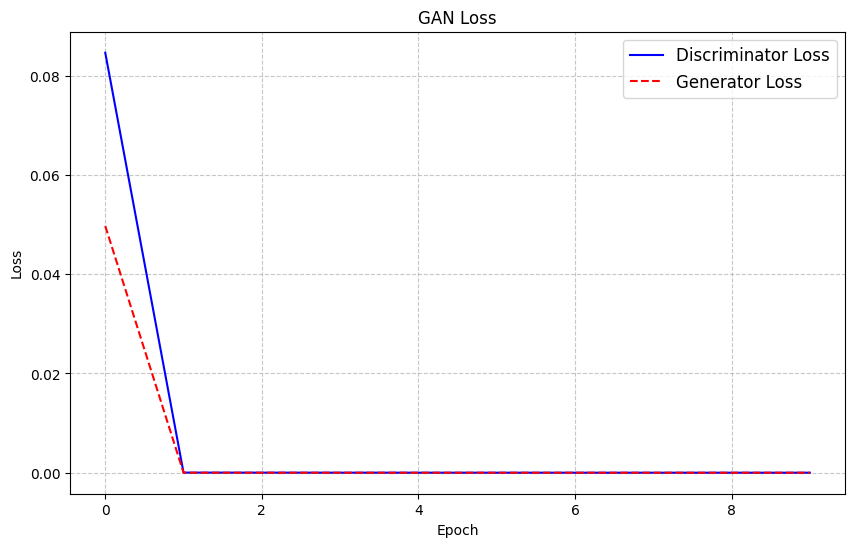

In [39]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['discriminator_loss'], label='Discriminator Loss', linestyle='-', color='b')
plt.plot(history.history['generator_loss'], label='Generator Loss', linestyle='--', color='r')
plt.title('GAN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='large')
plt.grid(True, linestyle='--', alpha=0.7)

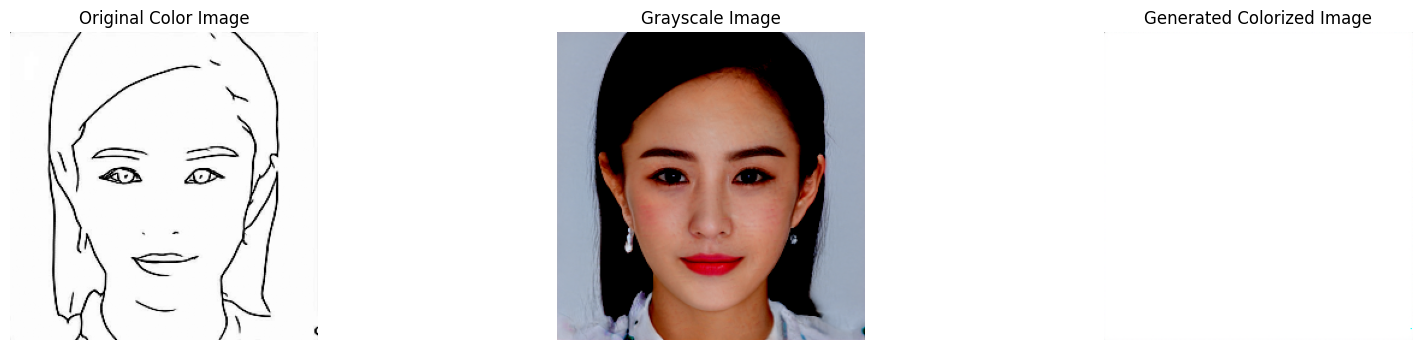

In [43]:
for black_image, color_image in test_dataset.take(1):
    for i in range(1):
        expanded_black_image = tf.expand_dims(black_image[i], axis=0)
        gen_image = pix2pix.generator(expanded_black_image)[0]

        plt.figure(figsize=(20, 4))
        plt.subplot(1, 3, 1)
        plt.title('Original Color Image')
        plt.imshow(color_image[i].numpy())
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Grayscale Image')
        plt.imshow(expanded_black_image[0].numpy(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Generated Colorized Image')
        plt.imshow((gen_image.numpy()+1)/2)
        plt.axis('off')
        plt.show()

# Saving and Loading Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pix2pix.generator.save("image_colorization")
loaded_model = tf.keras.models.load_model("image_colorization")

1/1 [==============================] - 0s 74ms/step


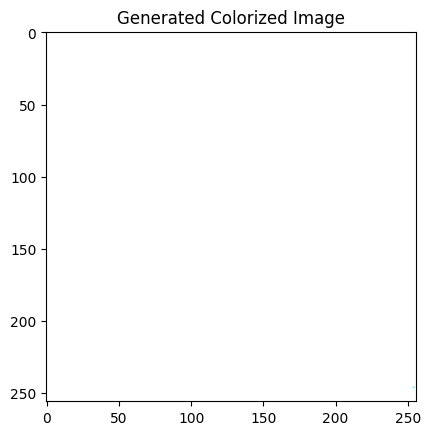

In [54]:
image_path = "/content/dataset/face/face/000025.png"
IMG_SIZE = 256
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
gen_image = pix2pix.generator.predict(image)
gen_image = (gen_image[0] + 1) / 2
plt.title('Generated Colorized Image')
plt.imshow(gen_image)

In [48]:
gen_image

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

# Creating Gif

In [ ]:
from PIL import Image
import os

images_folder = "/content/generated"
gif_filename = "Colorization_Images.gif"

images = []
for filename in sorted(os.listdir(images_folder)):
  if filename.endswith(".png"):
    filepath = os.path.join(images_folder, filename)
    img = Image.open(filepath)
    images.append(img)

images[0].save(gif_filename, save_all=True,
              append_images=images[1:],
              duration=50,
              loop=0)

# Model at inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = pix2pix.generator, repo_id = "DriveMyScream/Image_Colorization")

keras_metadata.pb:   0%|          | 0.00/184k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

fingerprint.pb:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/962k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/235M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/Image_Colorization/tree/main/'

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Image_Colorization")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
def convert_to_grayscale_with_channels(image):
    gray_image = tf.image.rgb_to_grayscale(image)
    gray_image = tf.image.grayscale_to_rgb(gray_image)
    return gray_image

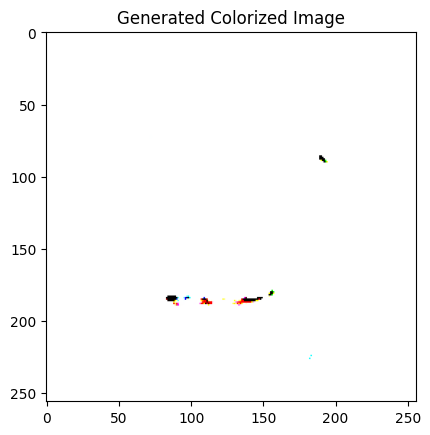

In [ ]:
image_path = "/content/dataset/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg"
IMG_SIZE = 256
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
image = convert_to_grayscale_with_channels(image)
gen_image = loaded_model(image)[0]
gen_image = (gen_image + 1) / 2
plt.title('Generated Colorized Image')
plt.imshow(gen_image.numpy())

# Tensorflow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pix2pix.generator)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Image_Colorization.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
def convert_to_grayscale_with_channels(image):
    gray_image = tf.image.rgb_to_grayscale(image)
    gray_image = tf.image.grayscale_to_rgb(gray_image)
    return gray_image

In [ ]:
for black_image, color_image in test_dataset.take(1):
  sample_image = black_image
  break

KeyboardInterrupt: ignored

In [ ]:
sample_image

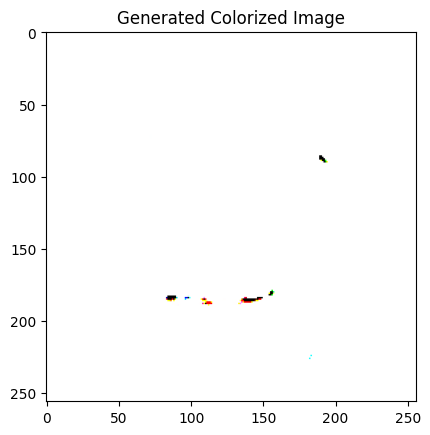

In [ ]:
tflite_model_path = "/content/drive/MyDrive/Image_Colorization.tflite"

interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image_path = "/content/dataset/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg"
IMG_SIZE = 256
image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
image = tf.cast(tf.image.resize(image, [IMG_SIZE, IMG_SIZE]), dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()
output_image = interpreter.get_tensor(output_details[0]['index'])
output_image = (output_image + 1) / 2
plt.title('Generated Colorized Image')
plt.imshow(output_image[0])
plt.show()